# Lab 3: Generating Data

Based on assignments by Lisa Zhang and Jimmy Ba.

In this lab, you will build models to perform image colourization. That is, given a greyscale image, we wish to predict the colour at each pixel. Image colourization is a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings.

To keep the training time manageable we will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. The data loading script is included with the notebooks, and should download automatically the first time it is loaded. 

We will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part of the assignment we will compare the autoencoder approach to conditional generative adversarial networks (cGANs).

In the process, you are expected to learn to:

1. Clean and process the dataset and create greyscale images.
2. Implement and modify an autoencoder architecture.
3. Tune the hyperparameters of an autoencoder.
4. Implement skip connections and other techniques to improve performance.
5. Implement a cGAN and compare with an autoencoder.
6. Improve on the cGAN by trying one of several techniques to enhance training.


### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/12ZlfsF6V6tSwOs5WLcPui6ko_XrHb-xt?usp=sharing

# PART A - Autoencoder [20 pt]

In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data. Note that you will need to use the Colab GPU for this assignment.

In [ ]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# provide your code here
!pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3


/content/a3


In [ ]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz
Extracting file.


## Part 1. Data Preparation [7 pt]

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks. 

### Part (a) [1pt]
Verify that the dataset has loaded correctly. How many samples do we have? How is the data organized?

In [ ]:
# code to examine the dataset

len(m[0][0]) # shape of xtrain


50000

In [ ]:
len(m[1][0]) # shape of xtest

10000

We have 2 sets of values in the data. The first set contains the training set with features and target and the second set contains the test set with the features and target.

50000 samples in x_train
10000 samples in x_test

### Part (b) [2pt]
Preprocess the data to select only images of horses. Learning to generate only hourse images will make our task easier. Your function will also convert the colour images to greyscale to create our input data.

In [ ]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


### Part (c) [2pt]
Create a dataloader (or function) to batch the samples.

In [ ]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)

### Part (e) [2pt]
Verify and visualize that we are able to generate different batches of data.

In [ ]:
# code to load different batches of horse dataset

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)


Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...


In [ ]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [ ]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (5000, 3, 32, 32) (5000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches

In [ ]:
# obtain batches of images
xs, ys = next(iter(get_batch(train_grey, train_rgb, 10)))
print(xs.shape, ys.shape)

(10, 1, 32, 32) (10, 3, 32, 32)


Visualization

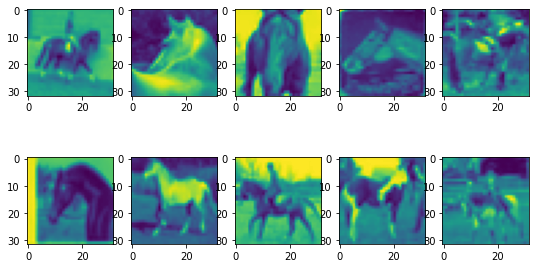

In [ ]:
# visualize 5 train/test images

plt.figure(figsize=(9, 5))

#train = train_grey.numpy()

#test = test_grey.numpy()

for i,img in enumerate(train_grey):

    if i >= 5: break

    plt.subplot(2, 5, i+1)

    img = np.squeeze(img)

    plt.imshow(img)

 

for i,img in enumerate(test_grey):

    if i >= 5: break

    plt.subplot(2, 5, 5+i+1)

    img = np.squeeze(img)

    plt.imshow(img)







## Part 2. Colourization as Regression [5 pt]

There are many ways to frame the problem of image colourization as a machine learning problem. One naive approach is to frame it as a regression problem, where we build a model to predict the RGB intensities at each pixel given the greyscale input. In this case, the outputs are continuous, and so squared error can be used to train the model.

In this section, you will get familar with training neural networks using cloud GPUs. Run the helper code and answer the questions that follow.

#### Helper Code

Regression Architecture

In [ ]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

Training code

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = np.zeros(args.epochs)
    valid_losses = np.zeros(args.epochs)
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        total_train_loss = 0.0
        total_epoch = 0
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
            total_train_loss += loss.data.item()
            total_epoch += len(labels)
        
        train_losses[epoch] = float(total_train_loss) / (i+1)
        print(epoch, loss.cpu().detach())

        total_loss = 0.0
        total_epoch = 0
        for i, (xs, ys) in enumerate(get_batch(test_grey, test_rgb, args.batch_size)):
                images, labels = get_torch_vars(xs, ys, args.gpu)
                outputs = gen(images)
                loss = criterion(outputs, labels)
                #valid_losses.append(loss.cpu().detach())
                total_loss += loss.data.item()
                total_epoch += len(labels)
        valid_losses[epoch] = float(total_loss) / (i + 1)
    
        
        if args.plot:
          visual(images, labels, outputs, args.gpu, 1)
    
    
    n = len(train_losses)
    plt.plot(range(1,n+1), train_losses, label="Train")
    plt.plot(range(1,n+1), valid_losses, label="Validation")
    plt.ylabel("Loss")
    plt.xlabel("epoch")
    plt.show()
             
    return gen

Training visualization code

In [ ]:
# visualize 5 train/test images
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

Main training loop for regression CNN

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

### Part (a) [1 pt]
Describe the model RegressionCNN. How many convolution layers does it have? What are the filter sizes and number of filters at each layer? Construct a table or draw a diagram.

Answer: Our RegressionCNN model has 6 convolutional layers. The filter sizes and number of filters at each layer is:
1. Filter size = 1 * 32 * 3 * 3 ,          number of filters = 32

2. Filter size = 32 * (32 * 2) * 3 * 3 ,   number of filters = 32 * 2

3. Filter size = (32 * 2) * 32 * 3 * 3 ,   number of filters = 32

4. Filter size = 32 * 32 * 3 * 3 ,         number of filters = 32

5. Filter size = 32 * 3 * 3 * 3 ,          number of filters = 3

6. Filter size = 3 * 3 * 3 * 3 ,           number of filters = 3



### Part (b) [1 pt]
Run the regression training code (should run without errors). This will generate some images. How many epochs are we training the CNN model in the given setting?

Answer: 25 epochs

### Part (c) [3 pt]
Re-train a couple of new models using a different number of training epochs. You may train each new models in a new code cell by copying and modifying the code from the last notebook cell. Comment on how the results (output images, training loss) change as we increase or decrease the number of epochs.

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 50,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Answer: As we increase the number of epochs, our model does not show much improvement.If we increase the number of epochs too much the model will start overfitting.

## Part 3. Skip Connections [8 pt]
A skip connection in a neural network is a connection which skips one or more layer and connects to a later layer. We will introduce skip connections.

### Part (a) [4 pt]
Add a skip connection from the first layer to the last, second layer to the second last, etc.
That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [3], and is called a "UNet". Following the CNN class that you have completed, complete the __init__ and forward methods of the UNet class.
Hint: You will need to use the function torch.cat.

In [ ]:
#complete the code

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters*2, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(4, 3, kernel_size=kernel, padding=padding)








    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        x_copy = x

        out = self.downconv1(x) # 32
        
        out_copy1 = out
        
        out = self.downconv2(out) # 64
        out_copy2 = out

        out = self.rfconv(out)  # 64

        #out = out +out_copy2
        out = torch.cat((out, out_copy2),dim =1)
        out = self.upconv1(out) # 32

        #out = out + out_copy1
        out = torch.cat((out, out_copy1),dim =1)
        out = self.upconv2(out) # 3

        out = torch.cat((out, x_copy),dim =1)
        out = self.finalconv(out)  # 3

        return out


In [ ]:
from torchsummary import summary
model = UNet(kernel = 3,num_filters =32 )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size = (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 32, 8, 8]          36,896
      BatchNorm2d-13             [-1, 32, 8, 8]              64
             ReLU-14             [-1, 3

### Part (b) [2 pt]
Train the "UNet" model for the same amount of epochs as the previous CNN and plot the training curve using a batch size of 100. How does the result compare to the previous model? Did skip connections improve the validation loss and accuracy? Did the skip connections improve the output qualitatively? How? Give at least two reasons why skip connections might improve the performance of our CNN models.

In [ ]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

The skip connection model did improve the validation loss.Also, it gave better color reproduction compared to the previous model. Skip connection provide an alternative path to the gradients.This helps us prevent the vanishing gradients problem.It also helps us pass lower layer information forward which ensures there is less loss of information.

### Part (c) [2 pt]
Re-train a few more "UNet" models using different mini batch sizes with a fixed number of epochs. Describe the effect of batch sizes on the training/validation loss, and the final image output.

In [ ]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)





In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 25,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

We observe that reducing the batch size gives us a lower loss for validation and training.The final image has better color reproduction.

# PART B - Conditional GAN [30 pt]

In this second half of the assignment we will construct a conditional generative adversarial network for our image colourization task.

## Part 1. Conditional GAN [15 pt]

To start we will be modifying the previous sample code to construct and train a conditional GAN. We will exploring the different architectures to identify and select our best image colourization model.

Note: This second half of the assignment should be started after the lecture on generative adversarial networks (GANs). 


### Part (a) [3 pt]
Modify the provided training code to implement a generator. Then test to verify it works on the desired input (Hint: you can reuse some of your earlier autoencoder models here to act as a generator)

In [ ]:
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters*2, kernel_size=kernel, padding=padding, stride = stride),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.rfconvlabel = nn.Sequential(
            nn.Conv2d(1, num_filters*2, kernel_size=kernel, padding=padding,stride = stride),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2, inplace=True))

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2, inplace=True),)
        
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),)
        self.finalconv = nn.ConvTranspose2d(3, 3, kernel_size=kernel, padding=padding)



    def forward(self, x, label):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        #noise = torch.randn(2, 1, 32, 32) # adding noise to the greyscale image
        
        out = self.rfconv(x) 
        label_out = self.rfconvlabel(label)
        out = torch.cat((out, label_out),dim =1)
        out = self.upconv1(out) # 32
        out = self.upconv2(out)  # 16
        out = self.upconv3(out) # 8
        out = self.finalconv(out) # 3
        return out

In [ ]:
#test generator architecture
from torchsummary import summary
model_gen = Generator(kernel = 3,num_filters =32 )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gen.to(device)
summary(model_gen,[(1,32,32),(1,32,32)])




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]             640
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         LeakyReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]             640
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         LeakyReLU-6           [-1, 64, 16, 16]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]          73,792
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         LeakyReLU-9           [-1, 64, 16, 16]               0
         Upsample-10           [-1, 64, 32, 32]               0
  ConvTranspose2d-11           [-1, 32, 32, 32]          18,464
      BatchNorm2d-12           [-1, 32, 32, 32]              64
        LeakyReLU-13           [-1, 32, 32, 32]               0
  ConvTranspose2d-14            [-1, 3,

### Part (b) [3 pt]
Modify the provided training code to implement a discriminator. Then test to verify it works on the desired input.

In [ ]:
# discriminator code

class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################

        self.downconv1 = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),)
        
        self.downconv1grey = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),)

        self.rfconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.rfconv2 = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*8, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*8),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.rfconv3 = nn.Sequential(
            nn.Conv2d(num_filters*8,1 , kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2, inplace=True))

        self.linear = nn.Sequential(
            nn.Linear(16 * 16*1, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid())
    
    
    def forward(self, x, img_greyscale):
        
        ############### YOUR CODE GOES HERE ###############
        ###################################################

        #fake_images = model_gen(noise,img_greyscale)
        
        out = self.downconv1(x) # 32
        #print(out.shape)
        gray_out = self.downconv1grey(img_greyscale)
        
        out = torch.cat((out, gray_out),dim =1)
        
        out = self.rfconv1(out) # 64
        #print(out.shape)
        

        out = self.rfconv2(out)  # 64
        #print(out.shape)

        out = self.rfconv3(out)
        #print(out.shape)

        out = out.view(-1, 1*16*16)

        out = self.linear(out)
        #print(out.shape)
        return out

In [ ]:
# test discriminator architecture
from torchsummary import summary

model_disc = Discriminator(kernel = 3,num_filters =32 )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_disc.to(device)
summary(model_disc,[(3,32,32),(1,32,32)])





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 32, 32, 32]             320
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         LeakyReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
        LeakyReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         295,168
      BatchNorm2d-13          [-1, 256, 16, 16]             512
        LeakyReLU-14          [-1, 256,

### Part (c) [3 pt]
Modify the provided training code to implement a conditional GAN.

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Generator(args.kernel,args.num_filters)
        discriminator = Discriminator(args.kernel,args.num_filters)


    # LOSS FUNCTION

    criterion = nn.BCELoss()                                               
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            #--->ADDED 5
            img_grey = images #grey
            img_real = labels #rgb
            batch_size = args.batch_size
            
            #discriminator training
            d_optimizer.zero_grad()

            # discriminator losses on real images 
            D_real = discriminator(img_real,img_grey)
            labels = torch.zeros(batch_size).cuda()
            d_real_loss = criterion(D_real.squeeze(), labels)
            
            # discriminator losses on fake images
            z = Variable(torch.randn(batch_size,1,32,32)).cuda()
            fake_images = cnn(z,img_grey)

            D_fake = discriminator(fake_images,img_grey)
            labels = torch.ones(batch_size).cuda() # fake labels = 1
            d_fake_loss = criterion(D_fake.squeeze(), labels)
            
            # add up losses and update parameters
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # generator training
            g_optimizer.zero_grad()
            z = Variable(torch.randn(batch_size,1,32,32)).cuda()
            fake_images = cnn(z,img_grey)
            validity = discriminator(fake_images, img_grey)
            g_loss = criterion(validity.squeeze(), Variable(torch.zeros(batch_size)).cuda())
            g_loss.backward()
            g_optimizer.step()


        # print and visualize
        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        visual(img_grey, img_real,fake_images, args.gpu, 1)

    return cnn

### Part (d) [3 pt]
Train a conditional GAN for image colourization.

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

#batch size of 50 with 100 epochs seamed to work

### Part (e) [1 pt]
How does the performance of the cGAN compare with the autoencoder models that you tested in the first half of this assignment?

Answer: The cGAN has much better results. The generated images have colours that are brighter and feel closer to the actual image.

### Part (f) [2 pt]

A colour space is a choice of mapping of colours into three-dimensional coordinates. Some colours could be close together in one colour space, but further apart in others. The RGB colour space is probably the most familiar to you, the model used in in our regression colourization example computes squared error in RGB colour space. But, most state of the art colourization models
do not use RGB colour space. How could using the RGB colour space be problematic? Your answer should relate how human perception of colour is different than the squared distance. You may use the Wikipedia article on colour space to help you answer the question.

Answer: The rgb colorspace requires the model to predict more values than it has to in other colorspaces because of the additional dimension.Human preception of color is different from rgb. humans have rods and cones in the eyes that percieve differnt things. Rods mostly transmit black and white images and cones transmit the higher intensity color images. So we separate according to the intensity and not see color as some combination of 3 colors like the rgb.Something like Lab is closer to how humans percieve color.

## Part 2. Exploration [10 pt]

At this point we have trained a few different generative models for our image colourization task with varying results. What makes this work exciting is that there many other approaches we could take. In this part of the assignment you will be exploring at least one of several approaches towards improving our performance on the image colourization task. Some well known approaches you can consider include:

- lab colour space representation instead of RBG which simplifies the problem and requires you to predict two output channels instead of three
- k-means to represent RBG colourspace by 'k' distinct colours, this effectively changes the problem from regression to classification.

Other interesting approaches include:
- combining L1 loss along with the discriminator-based loss
- starting with a pretrained generator (i.e. Resnet)
- patch discriminator trained on local regions

A great example of some of these different approaches can be found in a <a href="https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8">blog post by Moein Shariatnia</a>.

Note you are only required to pick one of the suggested modifications.

We have a pretrained generator that uses the resnet architecture and builds a unet from it. We pretrain it on our data and see that the results have improved.

In [ ]:
def build_res_unet(n_input=1, n_output=3, size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size,size))
    net_G.to(device)
    return net_G

In [ ]:
from fastai.vision.augment import true
def pretrain_generator(net_G, opt, criterion, epochs):
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    
    train_rgb, train_grey = process(x_train, y_train, downsize_input=False)

    for e in range(epochs):

      for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, 50)):
            images, labels = get_torch_vars(xs, ys, gpu = true)

            #--->ADDED 5
            img_grey = images.cuda() #grey
            img_real = labels.cuda() #rgb
            batch_size = 50
            preds = net_G(img_grey)
            loss = criterion(preds,img_real )
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            #loss_meter.update(loss.item(), L.size(0))
            
        #print(f"Epoch {e + 1}/{epochs}")
        

net_G = build_res_unet(n_input=1, n_output=3, size=32)
opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.MSELoss()       
pretrain_generator(net_G, opt, criterion, 20)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

File path: data/cifar-10-batches-py.tar.gz


In [ ]:
def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        #Net = globals()[args.model]
        cnn = net_G
        discriminator = Discriminator(args.kernel,args.num_filters)


    # LOSS FUNCTION

    criterion = nn.BCELoss()                                               
    #g_optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        #cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        #cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            #--->ADDED 5
            img_grey = images #grey
            img_real = labels #rgb
            batch_size = args.batch_size
            
            #discriminator training
            d_optimizer.zero_grad()

            # discriminator losses on real images 
            D_real = discriminator(img_real,img_grey)
            labels = torch.zeros(batch_size).cuda()
            d_real_loss = criterion(D_real.squeeze(), labels)
            
            # discriminator losses on fake images
            #z = Variable(torch.randn(batch_size,1,32,32)).cuda()
            fake_images = net_G(img_grey)

            D_fake = discriminator(fake_images,img_grey)
            labels = torch.ones(batch_size).cuda() # fake labels = 1
            d_fake_loss = criterion(D_fake.squeeze(), labels)
            
            # add up losses and update parameters
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            

        # print and visualize
        print(epoch, d_loss.cpu().detach()) #g_loss.cpu().detach()
        visual(img_grey, img_real,fake_images, args.gpu, 1)

    return cnn

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": net_G,
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 20,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)


## Part 3. New Data [5 pt]
Retrieve sample pictures from online and demonstrate how well your best model performs. Provide all your code.

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from PIL import Image

In [ ]:
# provide your code here
from google.colab import files
uploaded = files.upload()


Saving horse.zip to horse.zip


In [ ]:

!unzip "/content/horse.zip" -d "/content/horse"

Archive:  /content/horse.zip
  inflating: /content/horse/horse/horse1.s.jpg  
  inflating: /content/horse/horse/horse2.s.jpg  
  inflating: /content/horse/horse/horse3.s.jpg  
  inflating: /content/horse/horse/horse4.s.jpg  
  inflating: /content/horse/horse/horse5.s.jpg  


In [ ]:
transform = transforms.Compose([transforms.Resize((32, 32)), 
          transforms.ToTensor()
          ])
transform1 = transforms.Compose([transforms.Resize((32, 32)),transforms.Grayscale(), 
          transforms.ToTensor()
          ])

test_set = datasets.ImageFolder('/content/horse',transform = transform)  
gray_set = datasets.ImageFolder('/content/horse',transform = transform1)  

In [ ]:
device = torch.device('cuda')

In [ ]:
change_to_image = transforms.Compose([transforms.ToPILImage(), transforms.Resize((128, 128))])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


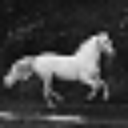

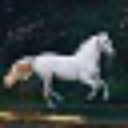

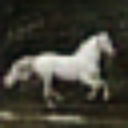

-------------------------------


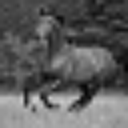

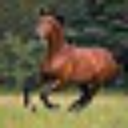

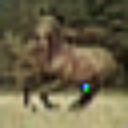

-------------------------------


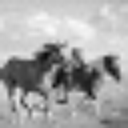

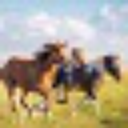

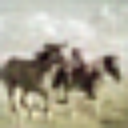

-------------------------------


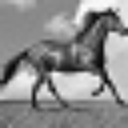

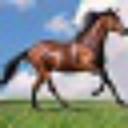

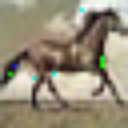

-------------------------------


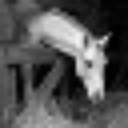

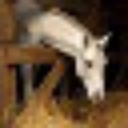

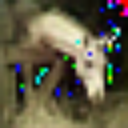

-------------------------------


In [ ]:
# testing our model on new images from the internet

net_G.eval()
discriminator = Discriminator(args.kernel,args.num_filters)
discriminator.to(device)
i=0
for imgs_in_batch, labels in iter(torch.utils.data.DataLoader(gray_set,1)):
    imgs_in_batch = imgs_in_batch.to(device)
    fake_images = net_G(imgs_in_batch)
    D_fake = discriminator(fake_images,imgs_in_batch)
    labels = torch.ones(1).cuda() # fake labels = 1
    d_fake_loss = criterion(D_fake.squeeze(), labels)
    
    # Displaying Images
    gray_image = change_to_image(imgs_in_batch[0])
    display(gray_image)
    actual_image = change_to_image(test_set[i][0])
    display(actual_image)
    colored_image = change_to_image(fake_images[0])
    display(colored_image)
    
    i = i+1
    print("-------------------------------")

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [4]:
%%shell
jupyter nbconvert --to html Image_colorization.ipynb

[NbConvertApp] Converting notebook Image_colorization.ipynb to html
[NbConvertApp] Writing 32345964 bytes to Image_colorization.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus